# Darcy streamfunction formulation

boundary value problem on $\textbf{x}\in\Omega$

$$\nabla\cdot\textbf{u} = 0$$
$$\textbf{u} = -\frac{\mathsf{K}}{\mu}\cdot\nabla p$$

streamfunction formulation

$$\textbf{u}=\nabla\times\boldsymbol{\psi} \iff \nabla\cdot\textbf{u}=0$$

$$\implies\nabla\times\left(\mu\mathsf{K}^{-1}\cdot\nabla\times\boldsymbol{\psi}\right) = \textbf{0}$$

$d=2$ Cartesian formulation

$$\implies\textbf{u}=\nabla\times\psi\textbf{e}_z=-\frac{\partial\psi}{\partial y}\textbf{e}_x + \frac{\partial\psi}{\partial x}\textbf{e}_y$$

$$\nabla\cdot\left(\frac{\mu\mathsf{K}^{\mathsf{T}}\cdot\nabla\psi}{\text{det}(\mathsf{K})}\right)=0$$

In [1]:
import numpy as np
from ufl.core.expr import Expr
from ufl import dx, Form, inner, TrialFunction, TestFunction, det, transpose

from lucifex.fem import LUCiFExFunction as Function, LUCiFExConstant as Constant
from lucifex.mesh import annulus_sector_mesh, mesh_boundary
from lucifex.fdm.ufl_operators import inner, grad
from lucifex.solver import BoundaryConditions, bvp_solver
from lucifex.viz import plot_contours, plot_mesh, plot_colormap
from lucifex.utils import is_tensor, DofsPerturbation
from lucifex.io import write


def darcy_streamfunction(
    psi: Function,
    k: Expr | Function | Constant | float,
    mu: Expr | Function | Constant | float,
) -> tuple[Form, Form]:
    v = TestFunction(psi.function_space)
    psi_trial = TrialFunction(psi.function_space)
    if is_tensor(k):
        F_lhs = -(mu / det(k)) * inner(grad(v), transpose(k) * grad(psi_trial)) * dx 
    else:
        F_lhs = -(mu / k) * inner(grad(v), grad(psi_trial)) * dx
    F_rhs = v * Constant(psi.function_space.mesh, 0.0) * dx
    return F_lhs, F_rhs

## Example: flow flow across an anticline of heterogeneous permeability

$$\Omega = \{(x,y)~:~~R_{\text{inner}}^2 < x^2 + y^2 < R_{\text{outer}}^2~,~y>0\}$$

$$\partial\Omega_{\text{upper}} = \{(x,y)~:~x^2 + y^2 < R_{\text{outer}}^2\}$$

$$\partial\Omega_{\text{lower}} = \{(x,y)~:~x^2 + y^2 < R_{\text{inner}}^2\}$$

$$\partial\Omega_{\text{in}} = \{(x,y)~:~y=0~,~-R_{\text{outer}}<x<-R_{\text{inner}}\}$$

$$\partial\Omega_{\text{out}} = \{(x,y)~:~y=0~,~R_{\text{inner}}<x<R_{\text{outer}}\}$$

$\psi\vert_{\partial\Omega}$ is piecewise continuous and satisfies the incompressibility constraint.

$$(\textbf{n}\cdot\textbf{u})\vert_{\partial\Omega_{\text{upper}}}=0\implies\psi\vert_{\partial\Omega_{\text{upper}}}=0$$

$$(\textbf{n}\cdot\textbf{u})\vert_{\partial\Omega_{\text{in}}}=-u_{\text{in}}\implies\psi\vert_{\partial\Omega_{\text{in}}}=-u_{\text{in}}(x+R_{\text{outer}})$$

$$(\textbf{n}\cdot\textbf{u})\vert_{\partial\Omega_{\text{lower}}}=0\implies\psi\vert_{\partial\Omega_{\text{lower}}}=-u_{\text{in}}(R_{\text{outer}}-R_{\text{inner}})$$

$$(\textbf{n}\cdot\textbf{u})\vert_{\partial\Omega_{\text{out}}}=u_{\text{in}}\implies\psi\vert_{\partial\Omega_{\text{out}}}=u_{\text{in}}(x-R_{\text{outer}})$$

$$\mathsf{K}(\textbf{x})=\mathcal{N}(\textbf{x})\mathsf{I}$$

$$\mu=1$$

In [2]:
Rinner = 1.0
Router = 2.0
Nradial = 10
dr = (Router - Rinner) / Nradial
mesh = annulus_sector_mesh(dr, 'triangle', 'anticline')(Rinner, Router, 180)

r2 = lambda x: x[0]**2 + x[1]**2
boundary = mesh_boundary(
    mesh, 
    {
        "lower": lambda x: r2(x) - Rinner**2,
        "upper": lambda x: r2(x) - Router**2,
        "in": lambda x: np.logical_and(np.isclose(x[1], 0.0), x[0] < 0),
        "out": lambda x: np.logical_and(np.isclose(x[1], 0.0), x[0] > 0),
    },
)

mu = Constant(mesh, 1.0)
k_lims = (0.05, 1.0)
k_noise = DofsPerturbation(
    0.0,
    1234,
    k_lims,
    (16, 16)
)
k = k_noise.combine_base_noise((mesh, 'P', 1), name='k')

psi = Function((mesh, 'P', 2), name='psi')
u_in = 1.0
psi_bcs = BoundaryConditions(
    ('dirichlet', boundary['upper'], 0.0),
    ('dirichlet', boundary['in'], lambda x: -u_in * (x[0] + Router)),
    ('dirichlet', boundary['lower'], -u_in * (Router - Rinner)),
    ('dirichlet', boundary['out'], lambda x: u_in * (x[0] - Router)),
)
psi_solver = bvp_solver(darcy_streamfunction, psi_bcs)(psi, k, mu)
psi_solver.solve()

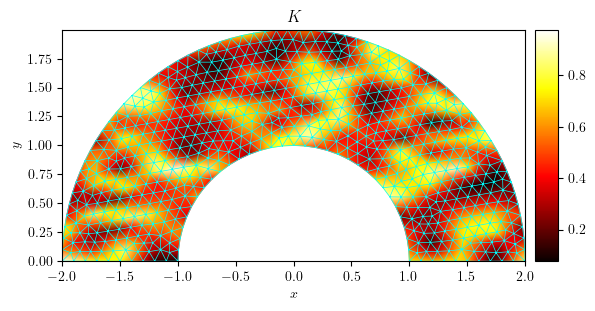

In [3]:
fig, ax = plot_colormap(k, title='$K$', x_label='$x$', y_label='$y$')
plot_mesh(fig, ax, mesh, color='cyan', linewidth=0.5)
write(fig, 'A10_darcy_streamfunction_k_mesh', './figures', file_ext=['pdf', 'png'], close=False, pickle=False)

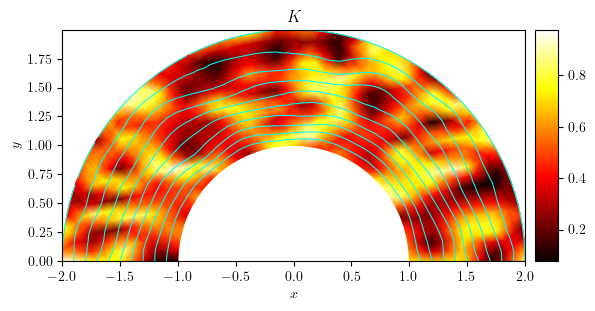

: 

In [ ]:
fig, ax = plot_colormap(k, title='$K$', x_label='$x$', y_label='$y$')
plot_contours(fig, ax, psi, colors='cyan', levels=10)
write(fig, f'A10_darcy_streamfunction_k_streamlines', './figures', file_ext=['pdf', 'png'], close=False, pickle=False)